In [80]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [81]:
# hyperparameters
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = torch.device('mps')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eval_iters = 2000
n_embd = 384
n_layers = 6
dropout = 0.2
n_head = 6

In [82]:

with open('tinyshakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
def encode(s): return [stoi[ch] for ch in s]
def decode(l): return ''.join([itos[i] for i in l])


# Split in to train anv validation
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    return x, y


print(encode("HELLO"))

[20, 17, 24, 24, 27]


In [83]:

class Transformer(nn.Module):  # not actually a bigram model anymore
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_layers) for _ in range(n_layers)]
        )
        self.final_ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B,T) tensors. where B is batch size and T is the number of tokens in each sequence (block_size*batch_size)

        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.final_ln(x) # (B,T,C)
        logits = self.lm_head(x)  # (B,T,V)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # crop idx
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=-1)
        return idx


class Head(nn.Module):
    '''a single self attention head'''

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5)  # (B,T,T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B,T,C)
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        # Q. what is proj an abbreviation for? A. projection Q. What is meant by projection? A. I think it means that the output is the same size as the input.3
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)  # (B,T,C)
        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class LayerNorm(nn.Module):

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        # calculate the forward pass

        xmean = x.mean(1, keepdim=True)  # batch mean
        xvar = x.var(1, keepdim=True)  # batch variance

        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [84]:
m = Transformer().to(device)
print(f'Number of parameters: {sum(p.numel() for p in m.parameters())}')

Number of parameters: 10788929


In [85]:
import torch
import time
import datetime

# Training loop
optimizer = torch.optim.Adam(m.parameters(), lr=learning_rate)
lossi = []
start_time = time.time()  # Record the starting time

for steps in range(max_iters):
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossi.append(loss.log10().item())
    
    if steps % eval_interval == 0:
        current_time = time.time() - start_time
        formatted_time = str(datetime.timedelta(seconds=current_time))
        print(f'step: {steps}, loss: {loss.item()}, time taken: {formatted_time}')

        # Estimate remaining time
        steps_remaining = max_iters - steps
        time_per_step = current_time / (steps + 1)  # Avoid division by zero
        remaining_time = datetime.timedelta(seconds=steps_remaining * time_per_step)
        print(f'estimated time remaining: {remaining_time}')

# Optionally, you can print the total training time
total_time = time.time() - start_time
formatted_total_time = str(datetime.timedelta(seconds=total_time))
print(f'Total training time: {formatted_total_time}')


step: 0, loss: 4.277246475219727, time taken: 0:00:02.321203
estimated time remaining: 3:13:26.016159


KeyboardInterrupt: 

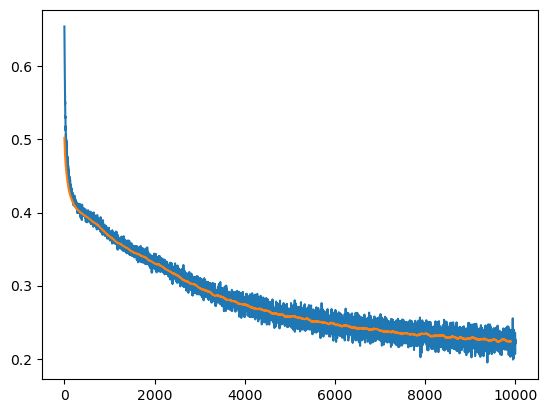

In [ ]:
plt.plot(lossi)
lossi_means = [sum(lossi[i:i+100])/100 for i in range(len(lossi)-100)]
plt.plot(lossi_means)
plt.show()

In [ ]:
# Evaluation loop over validation set

with torch.no_grad():
    total_loss = 0
    for steps in range(eval_iters):
        xb, yb = get_batch('val')
        xb, yb = xb.to(device), yb.to(device)
        logits, loss = m(xb, yb)
        total_loss += loss.item()
    print(f'validation loss: {total_loss/eval_iters}')

validation loss: 1.8577244211435318


In [ ]:
# Generate some text
idx = torch.zeros((1, 1), dtype=torch.long).to(device)
print(decode(m.generate(idx, 500)[0].tolist()))


eAryoH  NQl onioI to  a f mLA s h   we D ia noniv hr  s   wn pveoiP ui w     l-  , t R?e a rq b
h r       
ws

 s  lr x mGid  y  uo srP Ji  yohrr   eE a ty M   ha?nLt e a t &onT  waid  i o b mD QtBs rh 
E the pr  t a l her  oj c s Q I  Z h i he sIorL
&lt ar nA npo is  BlZ mf   M   as sla e -i  X a
 o ,g a 
M- o  ?    rqL, o Of  r   $   E3 r   , uit  or g s  r i otr  GIs  r  so ,  r silin  s a s G o V   a e t r n a  n'Vn ,! n oj  r, ynfR HC  R    r m s Xto ish m  sfad H mYn t It  Jdw  e X        


In [ ]:
#Save the model
torch.save(m.state_dict(), 'model.pt')
